# Using Deep Learning to Quantify Fibrosis in Muscle Tissue
## Production Code
## By Sergei Issaev

# Source and model files

In [1]:
source_file = '/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_marine_sept2020/DMSO_89C5_Dia_PSR_X10/source.jpg'
model_file = '/home/sergei/projects/def-rogertam/sergei/micro_scans/models/nov14ep110/model_048000.h5'

# Import Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from patchify import patchify, unpatchify
from skimage.util.shape import view_as_blocks
from keras.models import load_model
from numpy import load
import threshold_fx
import random
RANDOM_STATE = 42
np.random.seed(19680801)
print('Environment Ready')
%matplotlib inline

Using TensorFlow backend.


Environment Ready


# Get patches

In [3]:
im1 = cv2.imread(source_file)
(h1, w1, d1) = im1.shape
width = w1 // 256
height = h1 // 256
dim = (width * 256, height * 256)
im1 = cv2.resize(im1, dim, interpolation = cv2.INTER_AREA) 
im1 = view_as_blocks(im1, block_shape=(256, 256, 3)).squeeze()
ims1  = im1.reshape(-1, 256, 256, 3) 
state = ims1
# scale from [0,255] to [-1,1]
ims1 = (ims1 - 127.5) / 127.5
# load model
model = load_model(model_file, compile=False)

# Threshold Image

In [4]:
#Initialize variables
white = 0
black = 0
white_arr = list()
black_arr = list()
gen_arr = list()
samples = ims1.shape[0]
thresher = np.zeros((371, 256, 256))
genner = np.zeros((371, 256, 256, 3))

In [5]:
%%time
for i in range(samples):
    source = ims1[[i]]
    gen_image = model.predict(source)
    gen = (gen_image + abs(gen_image.min())) / 2.0
    white, black, thresh1 = threshold_fx.threshold_fx(state, i)
    if white != 0:
        gen_calc, threshgen = threshold_fx.threshold_gen(gen, white)  
    else:
        gen_calc = 0
        threshgen = np.zeros((thresh1.shape))
    gen_arr.append(gen_calc)
    white_arr.append(white)
    black_arr.append(black)
    thresh1 = np.expand_dims(thresh1, axis = 0)
    genner[i] = gen
    thresher[i] = thresh1
    black_tot = sum(black_arr)
    white_tot = sum(white_arr)
    gen_total = sum(gen_arr)

CPU times: user 4min 31s, sys: 13.8 s, total: 4min 45s
Wall time: 1min 34s


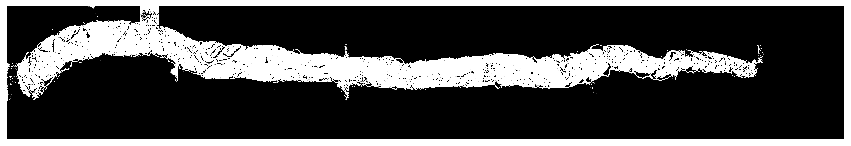

The percentage of tissue in this image is 19.24%.


In [6]:
multiple = 0
for a in range(height):
    for k in range(width):
        if k == 0:
            im_h = thresher[k + (width * multiple)]
        else: 
            im_h = cv2.hconcat([im_h, thresher[k + (width * multiple)]])
    plt.imshow(im_h, cmap="gray")
    plt.axis('off')
    plt.show()
    multiple += 1
    if a == 0:
        soos = im_h
    else:
        soos = cv2.vconcat([soos, im_h])
soos = cv2.resize(soos, (w1, h1), interpolation = cv2.INTER_AREA) 
plt.figure(figsize=(15,10))
plt.imshow(soos, cmap='gray')
plt.axis('off')
plt.show()

thresholded = soos * 255

cv2.imwrite('output.png', thresholded)
print(f"The percentage of tissue in this image is {round((white_tot * 100) / (black_tot + white_tot), 2)}%.")

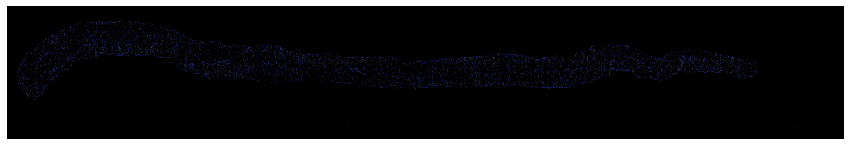

The percentage of fibrosis in the given image is 33.28%.


In [7]:
multiple = 0
for a in range(height):
    for k in range(width):
        if k == 0:
            im_h = genner[k + (width * multiple)]
        else: 
            im_h = cv2.hconcat([im_h, genner[k + (width * multiple)]])
    plt.imshow(im_h)
    plt.axis('off')
    plt.show()
    multiple += 1
    if a == 0:
        soos = im_h
    else:
        soos = cv2.vconcat([soos, im_h])
        
data = soos.astype(np.float64)
data = 255 * data
img = data.astype(np.uint8)
X_train = img
soos = cv2.cvtColor(X_train, cv2.COLOR_BGR2RGB)   
sooj = cv2.resize(X_train, (w1, h1), interpolation = cv2.INTER_AREA) 
plt.figure(figsize=(15,10))
plt.imshow(sooj)
plt.axis('off')
plt.show()        
        
fibrosis = round(((gen_total * 100) / white_tot), 2)
print(f"The percentage of fibrosis in the given image is {fibrosis}%.")

In [8]:
cv2.imwrite('stupid1.png', sooj)

True

In [9]:
model = load_model(model_file, compile=False)
model.name = "Generator"

In [10]:
model.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_6[0][0]              
__________________________________________________________________________________________

In [11]:
layer_outputs = [layer.output for layer in model.layers[:23]]

In [12]:
layer_outputs

[<tf.Tensor 'input_3_1:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'conv2d_7_1/BiasAdd:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'leaky_re_lu_6_1/LeakyRelu:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'conv2d_8_1/BiasAdd:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_5_1/batchnorm/add_1:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'leaky_re_lu_7_1/LeakyRelu:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'conv2d_9_1/BiasAdd:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'batch_normalization_6_1/batchnorm/add_1:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'leaky_re_lu_8_1/LeakyRelu:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'conv2d_10_1/BiasAdd:0' shape=(None, 16, 16, 512) dtype=float32>,
 <tf.Tensor 'batch_normalization_7_1/batchnorm/add_1:0' shape=(None, 16, 16, 512) dtype=float32>,
 <tf.Tensor 'leaky_re_lu_9_1/LeakyRelu:0' shape=(None, 16, 16, 512) dtype=f

In [13]:
from keras import models
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [14]:
activation_model.name="First_Half_Model"
activation_model.summary()

Model: "First_Half_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 256)  

In [15]:
number = random.randint(0, samples)
source = ims1[[number]]
activations = activation_model.predict(source) # Returns a list of five Numpy arrays: one array per layer activation

In [16]:
layer_num = 0
for layer in activations:
    print(f"Layer #{layer_num}:\t {layer.shape}")
    layer_num += 1

Layer #0:	 (1, 256, 256, 3)
Layer #1:	 (1, 128, 128, 64)
Layer #2:	 (1, 128, 128, 64)
Layer #3:	 (1, 64, 64, 128)
Layer #4:	 (1, 64, 64, 128)
Layer #5:	 (1, 64, 64, 128)
Layer #6:	 (1, 32, 32, 256)
Layer #7:	 (1, 32, 32, 256)
Layer #8:	 (1, 32, 32, 256)
Layer #9:	 (1, 16, 16, 512)
Layer #10:	 (1, 16, 16, 512)
Layer #11:	 (1, 16, 16, 512)
Layer #12:	 (1, 8, 8, 512)
Layer #13:	 (1, 8, 8, 512)
Layer #14:	 (1, 8, 8, 512)
Layer #15:	 (1, 4, 4, 512)
Layer #16:	 (1, 4, 4, 512)
Layer #17:	 (1, 4, 4, 512)
Layer #18:	 (1, 2, 2, 512)
Layer #19:	 (1, 2, 2, 512)
Layer #20:	 (1, 2, 2, 512)
Layer #21:	 (1, 1, 1, 512)
Layer #22:	 (1, 1, 1, 512)


In [17]:
test = activations[22].squeeze()

In [18]:
shower = (test * 10).astype(np.uint8).reshape((16, 32))

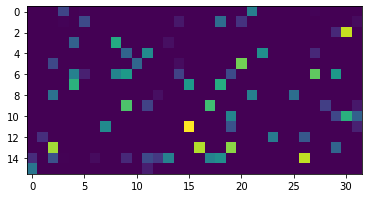

In [19]:
plt.imshow(shower)

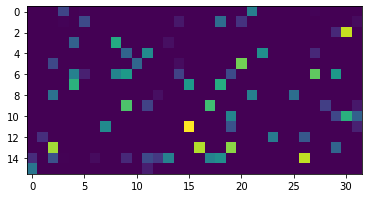

In [20]:
plt.imshow(shower)

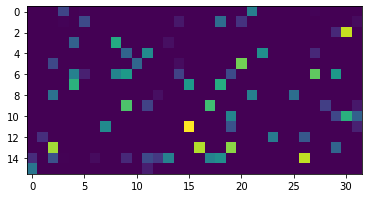

In [21]:
plt.imshow(shower)

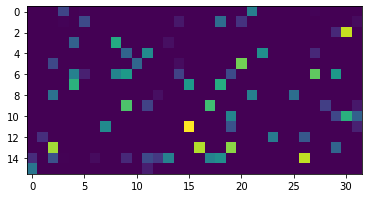

In [22]:
plt.imshow(shower)

In [23]:
from sklearn.decomposition import PCA

In [24]:
outputs = list()
for patch in range(samples):
    source = ims1[[patch]]
    activations = activation_model.predict(source) 
    output = activations[22].squeeze()
    outputs.append(output)

In [25]:
len(outputs)

308

In [26]:
outputs

[array([ 0.        ,  0.        ,  0.        ,  4.410858  ,  2.511836  ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.57083   ,  0.        ,  0.        ,  0.        ,
         0.        , 10.214897  ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.9265866 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         6.7714143 ,  0.        ,  3.7550538 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [27]:
pca_dims = PCA()
pca_dims.fit(outputs)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [28]:
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

7

In [29]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(outputs)
#X_sloth = pca.fit_transform(states_flat)

In [30]:
X_reduced[0]

array([-33.08658256,  35.50820637,  -9.77004724,   6.88059636,
         5.72206925,   1.19632762,  -6.5066465 ])

In [31]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(outputs)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print(f"total is {np.sum(pca.explained_variance_ratio_)}.")

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Explained variation per principal component: [0.68227056 0.14307915 0.05699722]
total is 0.88234692703076.


In [32]:
pca_one = (pca_result[:, 0])
pca_two = (pca_result[:, 1])
pca_three = (pca_result[:, 2])

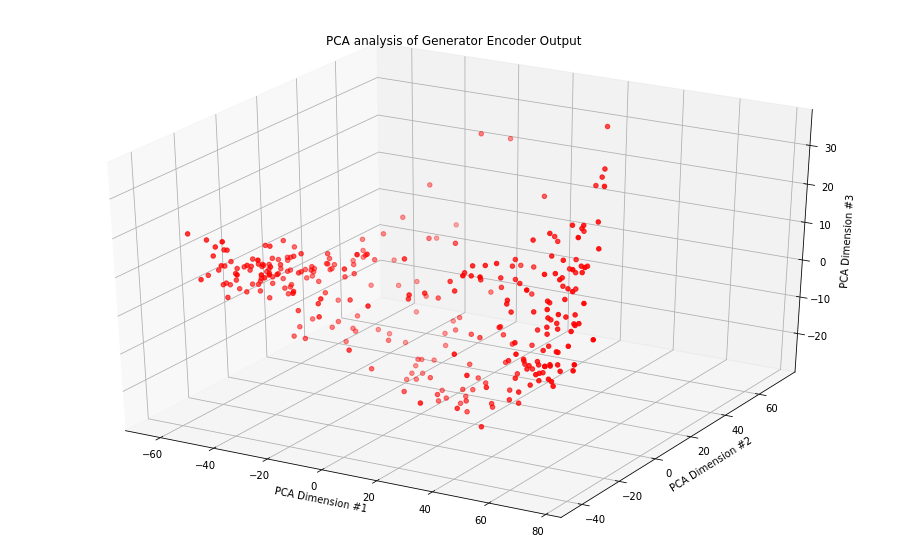

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
#for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
ax.scatter(pca_one, pca_two, pca_three, marker="o", color="red")
ax.set_xlabel('PCA Dimension #1')
ax.set_ylabel('PCA Dimension #2')
ax.set_zlabel('PCA Dimension #3')
plt.title("PCA analysis of Generator Encoder Output")
plt.show()

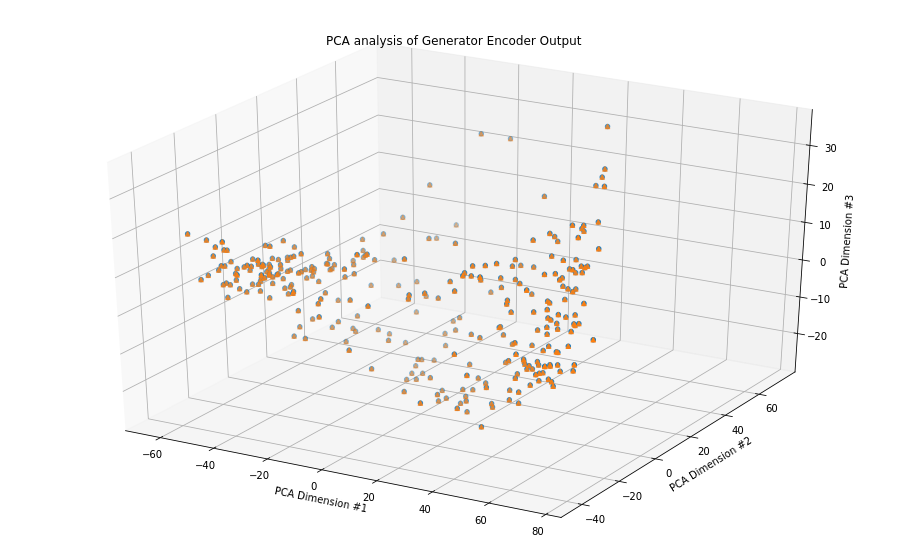

In [34]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    ax.scatter(pca_one, pca_two, pca_three, marker=m)
ax.set_xlabel('PCA Dimension #1')
ax.set_ylabel('PCA Dimension #2')
ax.set_zlabel('PCA Dimension #3')
plt.title("PCA analysis of Generator Encoder Output")
plt.show()

In [35]:
import os

randoms = os.listdir('/home/sergei/projects/def-rogertam/sergei/micro_scans/code_files/development/cats')

In [36]:
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]




In [37]:
dataset = load_real_samples('/home/sergei/projects/def-rogertam/sergei/micro_scans/data/traintest/diaphragmsmarinefascia4/train.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (747, 256, 256, 3) (747, 256, 256, 3)


In [38]:
outputs_1 = list()
source_ims = np.zeros((dataset[0].shape))
for patch in range(dataset[0].shape[0]):
    source = dataset[0][[patch]]
    source_ims[patch] = source
    activations = activation_model.predict(source) 
    output = activations[21].squeeze()
    outputs_1.append(output)

In [39]:
len(outputs_1)

747

In [40]:
len(randoms)

4

Initial Data Type: uint8
Initial Min: 0.000, Max: 255.000
Initial Mean: 119.925
added 30 to each pixel
New Mean: 122.344
New Min: 0.000, Max: 255.000
New Data Type: uint8
Final Data Type: uint8


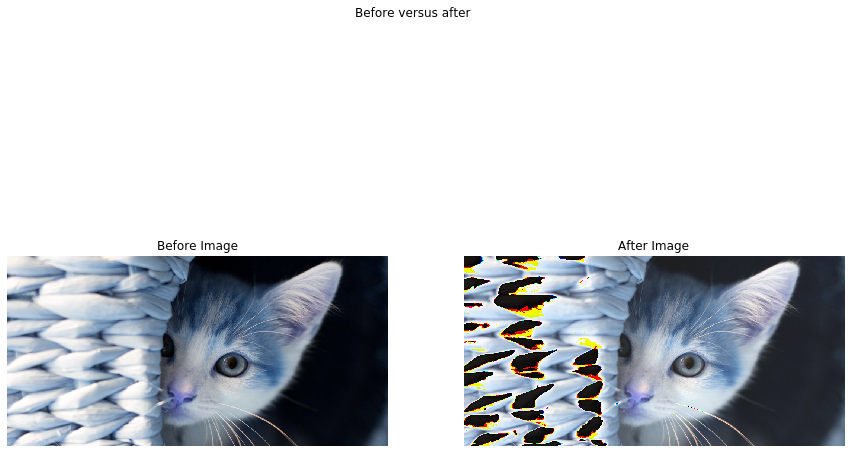

(8, 256, 256, 3)
747
patch is 0, outputs_1 is 747
patch is 1, outputs_1 is 748
patch is 2, outputs_1 is 749
patch is 3, outputs_1 is 750
patch is 4, outputs_1 is 751
patch is 5, outputs_1 is 752
patch is 6, outputs_1 is 753
patch is 7, outputs_1 is 754
747, 8
Initial Data Type: uint8
Initial Min: 0.000, Max: 237.000
Initial Mean: 97.393
added 52 to each pixel
New Mean: 148.626
New Min: 0.000, Max: 255.000
New Data Type: uint8
Final Data Type: uint8


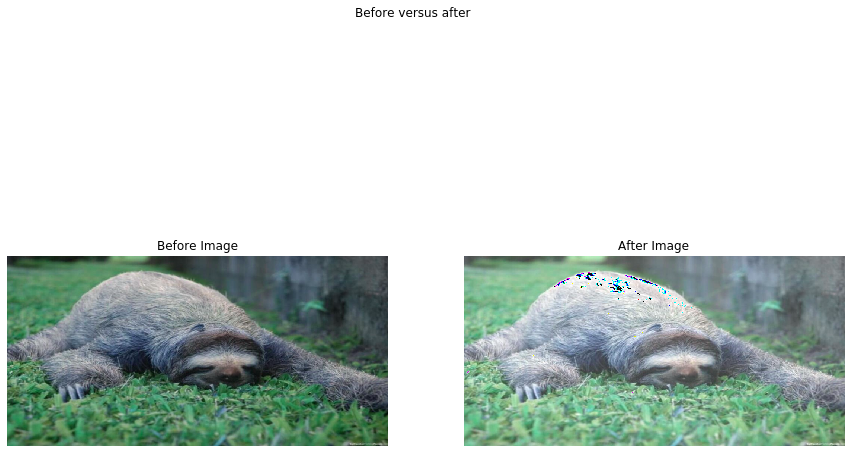

(8, 256, 256, 3)
755
patch is 0, outputs_1 is 755
patch is 1, outputs_1 is 756
patch is 2, outputs_1 is 757
patch is 3, outputs_1 is 758
patch is 4, outputs_1 is 759
patch is 5, outputs_1 is 760
patch is 6, outputs_1 is 761
patch is 7, outputs_1 is 762
755, 8
Initial Data Type: uint8
Initial Min: 0.000, Max: 255.000
Initial Mean: 113.813
added 36 to each pixel
New Mean: 146.412
New Min: 0.000, Max: 255.000
New Data Type: uint8
Final Data Type: uint8


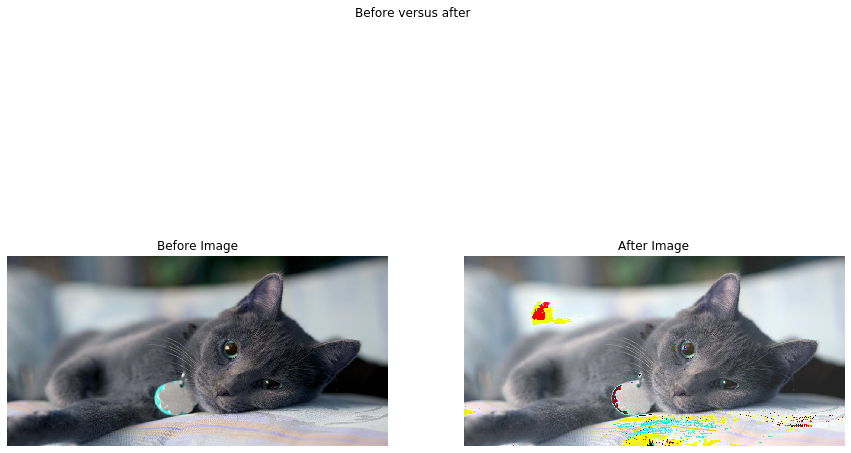

(8, 256, 256, 3)
763
patch is 0, outputs_1 is 763
patch is 1, outputs_1 is 764
patch is 2, outputs_1 is 765
patch is 3, outputs_1 is 766
patch is 4, outputs_1 is 767
patch is 5, outputs_1 is 768
patch is 6, outputs_1 is 769
patch is 7, outputs_1 is 770
763, 8
Initial Data Type: uint8
Initial Min: 0.000, Max: 255.000
Initial Mean: 82.843
added 67 to each pixel
New Mean: 125.376
New Min: 0.000, Max: 255.000
New Data Type: uint8
Final Data Type: uint8


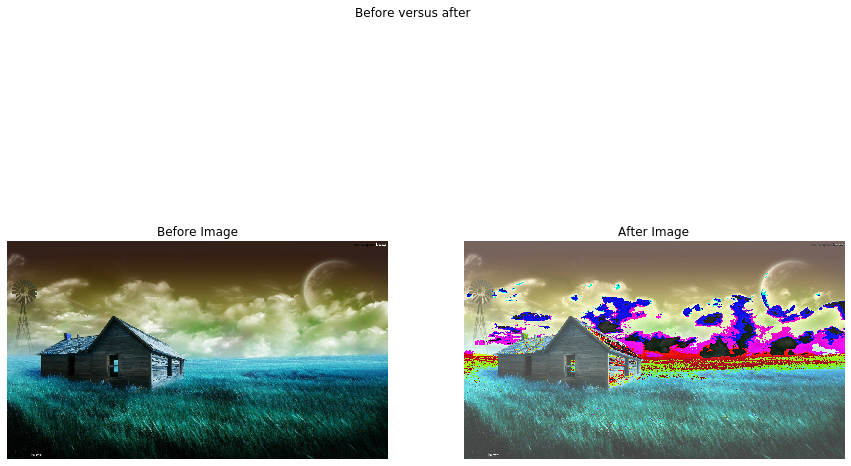

(28, 256, 256, 3)
771
patch is 0, outputs_1 is 771
patch is 1, outputs_1 is 772
patch is 2, outputs_1 is 773
patch is 3, outputs_1 is 774
patch is 4, outputs_1 is 775
patch is 5, outputs_1 is 776
patch is 6, outputs_1 is 777
patch is 7, outputs_1 is 778
patch is 8, outputs_1 is 779
patch is 9, outputs_1 is 780
patch is 10, outputs_1 is 781
patch is 11, outputs_1 is 782
patch is 12, outputs_1 is 783
patch is 13, outputs_1 is 784
patch is 14, outputs_1 is 785
patch is 15, outputs_1 is 786
patch is 16, outputs_1 is 787
patch is 17, outputs_1 is 788
patch is 18, outputs_1 is 789
patch is 19, outputs_1 is 790
patch is 20, outputs_1 is 791
patch is 21, outputs_1 is 792
patch is 22, outputs_1 is 793
patch is 23, outputs_1 is 794
patch is 24, outputs_1 is 795
patch is 25, outputs_1 is 796
patch is 26, outputs_1 is 797
patch is 27, outputs_1 is 798
771, 28


In [41]:
for rand in randoms:
    im1 = cv2.imread('/home/sergei/projects/def-rogertam/sergei/micro_scans/code_files/development/cats/' + rand)
    (h1, w1, d1) = im1.shape
    width = w1 // 256
    height = h1 // 256
    dim = (width * 256, height * 256)
    im1 = cv2.resize(im1, dim, interpolation = cv2.INTER_AREA) 
    
    
    
    
    
    print('Initial Data Type: %s' % im1.dtype)
    print('Initial Min: %.3f, Max: %.3f' % (im1.min(), im1.max()))
    mean = im1.mean()
    print('Initial Mean: %.3f' % mean)
    revert = im1
    # global centering of pixels
    add = int(150 - mean)
    im1 = im1 + add
    print('added', add, 'to each pixel')
    # confirm it had the desired effect
    im1 = np.clip(im1, 0, 255)
    mean = im1.mean()
    print('New Mean: %.3f' % mean)
    print('New Min: %.3f, Max: %.3f' % (im1.min(), im1.max()))
    print('New Data Type: %s' % im1.dtype)
    im1 = im1.astype('uint8')
    print('Final Data Type: %s' % im1.dtype)


    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
    fig.suptitle(f"Before versus after")
    ax[0].set_title(f'Before Image')
    ax[0].imshow(revert, cmap='gray')
    ax[0].axis('off')
    ax[1].set_title('After Image')
    ax[1].imshow(im1, cmap='gray')
    ax[1].axis('off')
    plt.show()

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    im1 = view_as_blocks(im1, block_shape=(256, 256, 3)).squeeze()
    ims1  = im1.reshape(-1, 256, 256, 3) 
    state = ims1
    # scale from [0,255] to [-1,1]
    ims1 = (ims1 - 127.5) / 127.5

    print(ims1.shape)
    print(len(outputs_1))
    source_ims_non = np.zeros((ims1.shape))
    for patch in range(ims1.shape[0]):
        print(f"patch is {patch}, outputs_1 is {len(outputs_1)}")
        source = ims1[[patch]]
        source_ims_non[patch] = source
        
        activations = activation_model.predict(source) 
        output = activations[21].squeeze()
        outputs_1.append(output)
    print(f"{len(source_ims)}, {len(source_ims_non)}")
    source_ims = np.concatenate((source_ims, source_ims_non), axis = 0)

In [42]:
print(ims1.shape[0])
print(dataset[0].shape[0])

28
747


In [43]:

print(source_ims.shape)
print(source_ims_non.shape)
sources = source_ims
print(sources.shape)

(799, 256, 256, 3)
(28, 256, 256, 3)
(799, 256, 256, 3)


In [44]:
len(outputs_1)

799

In [45]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(outputs_1)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print(f"total is {np.sum(pca.explained_variance_ratio_)}.")

Explained variation per principal component: [0.39791291 0.27955719]
total is 0.6774700970680776.


In [46]:
pca_result.shape

(799, 2)

In [47]:

pca_one = (pca_result[:747, 0])
pca_two = (pca_result[:747, 1])


pca_four = (pca_result[747:, 0])
pca_five = (pca_result[747:, 1])


array_1 = [pca_one, pca_two]
array_2 = [pca_four, pca_five]

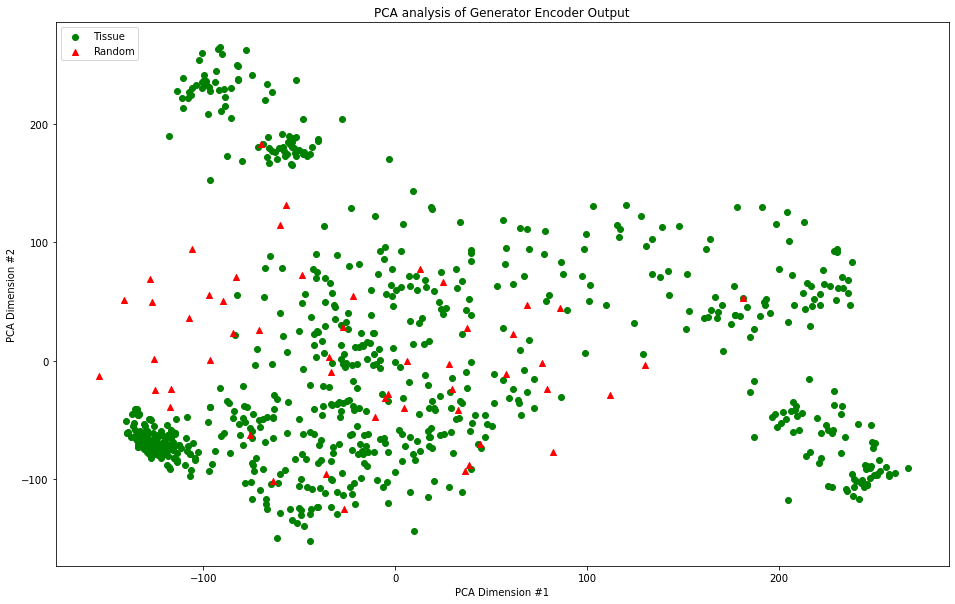

In [48]:
fig = plt.figure(figsize=(16, 10))
x = array_1[0]
y = array_1[1]

x2 = array_2[0]
y2 = array_2[1]


plt.scatter(x, y, c="g", marker="o",
            label="Tissue")
plt.scatter(x2, y2, c="r", marker="^",
            label="Random")
plt.xlabel("PCA Dimension #1")
plt.ylabel("PCA Dimension #2")
plt.legend(loc='upper left')
plt.title("PCA analysis of Generator Encoder Output")
plt.show()

In [49]:
axis_1 = np.concatenate((pca_one, pca_four), axis=0)
len(axis_1)

799

In [50]:
axis_2 = np.concatenate((pca_two, pca_five), axis=0)
len(axis_2)

799

In [51]:
classes = np.concatenate((np.zeros(len(pca_one)), np.ones(len(pca_four))), axis = 0)
print(len(classes))

799


In [52]:
embedding = [axis_1, axis_2, classes]

In [53]:
import pandas as pd
from io import BytesIO
from PIL import Image
import base64

In [54]:
def embeddable_image(data):
    img_data = data
    image = Image.fromarray(img_data)
    #image = image.resize((64, 64, 3), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [55]:
pca2_df = pd.DataFrame(embedding)
pca2_df = pca2_df.T
pca2_df.columns = ["x", "y", "class"]
print(f"Dataframe shape: {pca2_df.shape}")
pca2_df.sample(5)

Dataframe shape: (799, 3)


x           y  class
193  -53.773227  180.782786    0.0
269  192.551242   47.315456    0.0
223 -116.634362  -60.056854    0.0
731    9.056747   14.070135    0.0
177  -65.186230   88.327895    0.0

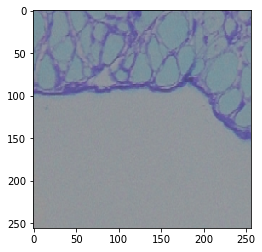

In [56]:
sources = (sources + 1.0) / 2.0

sources = 255 * sources
sources = sources.astype(np.uint8)


plt.imshow(sources[random.randint(0, sources.shape[0])], cmap='gray')
plt.show()

In [57]:
pca2_df['image'] = list(map(embeddable_image, sources))

In [58]:
pca2_df.sample(5)

x          y  class  \
719   19.115023 -74.244218    0.0   
29    23.832743  43.275083    0.0   
202   13.011291 -76.034620    0.0   
229  -24.261245 -32.859702    0.0   
234 -107.135444 -79.182700    0.0   

                                                 image  
719  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
29   data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
202  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
229  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
234  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...

In [59]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10, Spectral3

output_notebook()

Loading BokehJS ...

In [60]:
datasource = ColumnDataSource(pca2_df)

In [61]:
color_mapping = CategoricalColorMapper(factors=['0', '1'],
                                       palette=Spectral3)

In [62]:
plot_figure = figure(
    title='PCA projection of the Tissue dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

In [63]:
plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

In [64]:
plot_figure.circle(
    'x',
    'y',
    source=datasource

)

GlyphRenderer(id='1035', ...)

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='class', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)

In [65]:
show(plot_figure)

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(outputs_1)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print(f"total is {np.sum(pca.explained_variance_ratio_)}.")

In [ ]:

pca_one = (pca_result[:747, 0])
pca_two = (pca_result[:747, 1])
pca_three = (pca_result[:747, 2])

pca_four = (pca_result[747:, 0])
pca_five = (pca_result[747:, 1])
pca_six = (pca_result[747:, 2])


array_1 = [pca_one, pca_two, pca_three]
array_2 = [pca_four, pca_five, pca_six]

In [ ]:
pca_result

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for data, color, marker in [(array_1, "blue", 'o'), (array_2, "red", '^')]:
    ax.scatter(data[0], data[1], data[2], marker=marker, color=color)
ax.set_xlabel('PCA Dimension #1')
ax.set_ylabel('PCA Dimension #2')
ax.set_zlabel('PCA Dimension #3')
plt.title("PCA analysis of Generator Encoder Output")
plt.show()

In [ ]:
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in digits.target]
digits_df['image'] = list(map(embeddable_image, digits.images))

In [ ]:
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [ ]:
model.get_config()

In [ ]:
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
# load image data
dataset = load_real_samples('/home/sergei/projects/def-rogertam/sergei/micro_scans/data/traintest/diaphragmsmarinefascia4/train.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

In [ ]:
plt.imshow(dataset[0][10])

In [ ]:
training = dataset[0]
X_flat = np.array(training).reshape((747, 256 * 256 * 3))

In [ ]:
training[0]

In [ ]:
states = state / 255
states_flat = np.array(states).reshape((states.shape[0], 256 * 256 * 3))

In [ ]:
X_flat.shape

In [ ]:
pca_dims = PCA()
pca_dims.fit(X_flat)

In [ ]:
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

In [ ]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_flat)
X_sloth = pca.fit_transform(states_flat)

In [ ]:
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
X_reduced.shape

In [ ]:
X_reduced[0]

In [ ]:
for i in range(X_reduced.shape[0]):
    print((X_reduced[i][0]))

In [ ]:
X_reduced.shape

In [ ]:
i = random.randint(0, X_reduced.shape[0])
crazy = X_reduced[i] + abs(X_reduced[i].min())

In [ ]:
crazy

In [ ]:
data = crazy.astype(np.float64)
data = 4 * data
img = data.astype(np.uint8)
img

In [ ]:
crack = img.reshape((14, 26))
crack

In [ ]:
plt.imshow(crack, cmap='gray')

In [ ]:
plt.imshow(training[i], cmap='gray')

In [ ]:

crazy = X_reduced[i] + abs(X_reduced[i].min())

In [ ]:
crazy

In [ ]:
data = crazy.astype(np.float64)
data = 4 * data
img = data.astype(np.uint8)
img

In [ ]:
crack = img.reshape((14, 26))
crack

In [ ]:
plt.imshow(crack, cmap='gray')

In [ ]:
plt.imshow(training[i], cmap='gray')

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('resultsmay12.csv')
df

file  %thresh  %fibrosis
0   /home/sergei/projects/def-rogertam/sergei/micr...    21.50      48.58
1   /home/sergei/projects/def-rogertam/sergei/micr...    22.99      41.57
2   /home/sergei/projects/def-rogertam/sergei/micr...    22.85      43.89
3   /home/sergei/projects/def-rogertam/sergei/micr...    18.53      46.72
4   /home/sergei/projects/def-rogertam/sergei/micr...    13.69      44.42
5   /home/sergei/projects/def-rogertam/sergei/micr...    24.31      55.15
6   /home/sergei/projects/def-rogertam/sergei/micr...    23.84      45.98
7   /home/sergei/projects/def-rogertam/sergei/micr...    17.84      56.94
8   /home/sergei/projects/def-rogertam/sergei/micr...    11.03      51.61
9   /home/sergei/projects/def-rogertam/sergei/micr...    14.60      56.74
10  /home/sergei/projects/def-rogertam/sergei/micr...    16.99      57.58
11  /home/sergei/projects/def-rogertam/sergei/micr...    16.50      59.59
12  /home/sergei/projects/def-rogertam/sergei/micr...    15.46      58.22
13  /home/sergei/projects/def-rogertam/sergei/micr...    19.65      47.63
14  /home/sergei/projects/def-rogertam/sergei/micr...    13.28      60.81
15  /home/sergei/projects/def-rogertam/sergei/micr...    15.13      58.26
16  /home/sergei/projects/def-rogertam/sergei/micr...    17.86      63.38
17  /home/sergei/projects/def-rogertam/sergei/micr...    21.13      61.62
18  /home/sergei/projects/def-rogertam/sergei/micr...    18.81      56.50
19  /home/sergei/projects/def-rogertam/sergei/micr...    18.66      65.17
20  /home/sergei/projects/def-rogertam/sergei/micr...    14.17      55.68
21  /home/sergei/projects/def-rogertam/sergei/micr...    17.14      50.49
22  /home/sergei/projects/def-rogertam/sergei/micr...    13.61      31.02
23  /home/sergei/projects/def-rogertam/sergei/micr...    20.26      53.67
24  /home/sergei/projects/def-rogertam/sergei/micr...    19.22      57.32
25  /home/sergei/projects/def-rogertam/sergei/micr...    15.63      44.11
26  /home/sergei/projects/def-rogertam/sergei/micr...    20.15      52.26
27  /home/sergei/projects/def-rogertam/sergei/micr...    16.78      51.53
28  /home/sergei/projects/def-rogertam/sergei/micr...    16.85      61.49
29  /home/sergei/projects/def-rogertam/sergei/micr...    11.52      62.26
30  /home/sergei/projects/def-rogertam/sergei/micr...    12.61      39.69
31  /home/sergei/projects/def-rogertam/sergei/micr...    17.72      44.52
32  /home/sergei/projects/def-rogertam/sergei/micr...    23.44      42.01
33  /home/sergei/projects/def-rogertam/sergei/micr...    18.33      39.42
34  /home/sergei/projects/def-rogertam/sergei/micr...    19.94      50.18
35  /home/sergei/projects/def-rogertam/sergei/micr...    17.45      42.41
36  /home/sergei/projects/def-rogertam/sergei/micr...    19.61      50.80
37  /home/sergei/projects/def-rogertam/sergei/micr...    10.80      70.85
38  /home/sergei/projects/def-rogertam/sergei/micr...    12.60      56.43
39  /home/sergei/projects/def-rogertam/sergei/micr...    12.60      56.37
40  /home/sergei/projects/def-rogertam/sergei/micr...    18.09      44.01
41  /home/sergei/projects/def-rogertam/sergei/micr...    18.73      54.40
42  /home/sergei/projects/def-rogertam/sergei/micr...    25.20      54.32
43  /home/sergei/projects/def-rogertam/sergei/micr...    16.80      58.62
44  /home/sergei/projects/def-rogertam/sergei/micr...    22.88      57.91
45  /home/sergei/projects/def-rogertam/sergei/micr...    14.16      54.81
46  /home/sergei/projects/def-rogertam/sergei/micr...    13.55      55.30
47  /home/sergei/projects/def-rogertam/sergei/micr...    18.43      55.92
48  /home/sergei/projects/def-rogertam/sergei/micr...    18.13      56.99
49  /home/sergei/projects/def-rogertam/sergei/micr...    15.79      53.13
50  /home/sergei/projects/def-rogertam/sergei/micr...    10.35      52.51
51  /home/sergei/projects/def-rogertam/sergei/micr...    19.96      39.36
52  /home/sergei/projects/def-rogertam/sergei/micr...    15.84      37.01
53  /home/sergei/projects/def-rogertam/sergei/micr...

In [3]:
for file in df['file']:
    print(file)

/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/A1/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/A2/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/A3/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/A6/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/A7/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/A8/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/A9/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/B1/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/data/datafile_diaphragms_ben_feb2021/B2/source.png
/home/sergei/projects/def-rogertam/sergei/micro_scans/d

In [4]:
df_gt = pd.read_csv('resultsapr15gt.csv')
df_gt

file  %thresh  %fibrosis
0   /home/sergei/projects/def-rogertam/sergei/micr...    21.50      41.63
1   /home/sergei/projects/def-rogertam/sergei/micr...    22.99      22.29
2   /home/sergei/projects/def-rogertam/sergei/micr...    22.85      29.75
3   /home/sergei/projects/def-rogertam/sergei/micr...    18.53      30.23
4   /home/sergei/projects/def-rogertam/sergei/micr...    13.69      26.29
5   /home/sergei/projects/def-rogertam/sergei/micr...    24.31      35.69
6   /home/sergei/projects/def-rogertam/sergei/micr...    23.84      30.54
7   /home/sergei/projects/def-rogertam/sergei/micr...    17.84      26.50
8   /home/sergei/projects/def-rogertam/sergei/micr...    11.03      14.12
9   /home/sergei/projects/def-rogertam/sergei/micr...    14.60      30.77
10  /home/sergei/projects/def-rogertam/sergei/micr...    16.99      33.57
11  /home/sergei/projects/def-rogertam/sergei/micr...    16.50      24.27
12  /home/sergei/projects/def-rogertam/sergei/micr...    15.46      13.05
13  /home/sergei/projects/def-rogertam/sergei/micr...    19.65      21.16
14  /home/sergei/projects/def-rogertam/sergei/micr...    13.28      15.48
15  /home/sergei/projects/def-rogertam/sergei/micr...    15.13      18.11
16  /home/sergei/projects/def-rogertam/sergei/micr...    17.86      25.87
17  /home/sergei/projects/def-rogertam/sergei/micr...    21.13      20.48
18  /home/sergei/projects/def-rogertam/sergei/micr...    18.81      17.68
19  /home/sergei/projects/def-rogertam/sergei/micr...    18.66      15.12
20  /home/sergei/projects/def-rogertam/sergei/micr...    14.17      11.79
21  /home/sergei/projects/def-rogertam/sergei/micr...    17.14      15.19
22  /home/sergei/projects/def-rogertam/sergei/micr...    13.61      22.78
23  /home/sergei/projects/def-rogertam/sergei/micr...    20.26      19.62
24  /home/sergei/projects/def-rogertam/sergei/micr...    19.22      39.81
25  /home/sergei/projects/def-rogertam/sergei/micr...    15.63      45.24
26  /home/sergei/projects/def-rogertam/sergei/micr...    20.15      23.02
27  /home/sergei/projects/def-rogertam/sergei/micr...    16.78      21.04
28  /home/sergei/projects/def-rogertam/sergei/micr...    16.85      32.52
29  /home/sergei/projects/def-rogertam/sergei/micr...    11.52      19.97
30  /home/sergei/projects/def-rogertam/sergei/micr...    12.61      20.38
31  /home/sergei/projects/def-rogertam/sergei/micr...    17.72      12.37
32  /home/sergei/projects/def-rogertam/sergei/micr...    23.44      28.81
33  /home/sergei/projects/def-rogertam/sergei/micr...    18.33      40.04
34  /home/sergei/projects/def-rogertam/sergei/micr...    19.94      17.47
35  /home/sergei/projects/def-rogertam/sergei/micr...    17.45      22.33
36  /home/sergei/projects/def-rogertam/sergei/micr...    19.61      31.10
37  /home/sergei/projects/def-rogertam/sergei/micr...    10.80      32.61
38  /home/sergei/projects/def-rogertam/sergei/micr...    12.60      33.54
39  /home/sergei/projects/def-rogertam/sergei/micr...    12.60      33.54
40  /home/sergei/projects/def-rogertam/sergei/micr...    18.09      19.15
41  /home/sergei/projects/def-rogertam/sergei/micr...    18.73      26.24
42  /home/sergei/projects/def-rogertam/sergei/micr...    25.20      26.19
43  /home/sergei/projects/def-rogertam/sergei/micr...    16.80      49.28
44  /home/sergei/projects/def-rogertam/sergei/micr...    22.88      14.67
45  /home/sergei/projects/def-rogertam/sergei/micr...    14.16      28.64
46  /home/sergei/projects/def-rogertam/sergei/micr...    13.55      34.98
47  /home/sergei/projects/def-rogertam/sergei/micr...    18.43      36.51
48  /home/sergei/projects/def-rogertam/sergei/micr...    18.13      36.40
49  /home/sergei/projects/def-rogertam/sergei/micr...    15.79      28.51
50  /home/sergei/projects/def-rogertam/sergei/micr...    10.35       9.92
51  /home/sergei/projects/def-rogertam/sergei/micr...    19.96      16.86
52  /home/sergei/projects/def-rogertam/sergei/micr...    15.84      16.57
53  /home/sergei/projects/def-rogertam/sergei/micr...

In [5]:
df2 = pd.read_csv('cutter.csv')
df2

Key        HP     col1a1        fn1        Vim      Postn       il6  \
0   A1  4.728163  20.250000   5.305556  14.263889   6.152778  0.029167   
1   A2  4.391778  16.294118  15.541176  14.270588   5.705882  0.115294   
2   A3  3.195193  15.518341   4.688995  13.110048   3.110048  0.017544   
3   A6  4.606735  21.407307   4.194858   7.956698   4.600812  0.016238   
4   A7  4.847644  18.771429   4.219048  12.838095   6.009524  0.016190   
5   A8  4.565778  19.719495   7.419355   9.424965   4.025245  0.005891   
6   A9  5.366852  19.669604  17.092511  27.488987   1.804384  0.039648   
7   B1  5.924885  33.108808   6.813472   4.119171   8.678756  0.012176   
8   B2  4.901141  28.125000   4.375000  15.852273   5.312500  0.009375   
9   B3  5.500765  15.996080   4.194430   6.263262   7.285205  0.018223   
10  B4  5.001444  27.232558   4.883721  18.186047   6.488372  0.017442   
11  B5  4.561775  19.786096   4.438503  14.021390   4.823529  0.042781   
12  B6  5.855220  42.591549   5.042254  25.211268   8.901408  0.013521   
13  B8  5.632846  46.472303   5.218659  17.521866   6.793003  0.021574   
14  C1  2.980685  15.520408   2.397959  11.020408   3.010204  0.006327   
15  C2  3.707074  24.583333   5.240385  13.894231   7.660256  0.006891   
16  C3  4.984986  15.955882   4.460784  15.000000   3.848039  0.004412   
17  C4  4.431899  21.796610   6.271186  16.779661   4.847458  0.008814   
18  C5  4.845230  24.855491   6.069364  21.242775   5.173410  0.028035   
19  C6  4.908136  34.411765   6.013072  20.359477   5.555556  0.022876   
20  C7  4.316238  32.821997   4.732272  18.784370   6.136035  0.010275   
21  C8  4.956145  35.282258   5.564516  20.201613   4.375000  0.018952   
22  D1  4.599648  25.095541   4.840764   3.503185  10.806794  0.040340   
23  D2  5.678156  19.119601  11.411960   9.916944  18.289037  0.076412   
24  D3  6.889080  19.674797        NaN        NaN  19.288618  0.022358   
25  D4  5.600105  21.500000   3.877551   4.806122  14.132653  0.010204   
26  D5  5.287415  22.954990   4.422701   2.974560  12.328767  0.125245   
27  D6  5.807692  36.335404  21.987578  11.180124  25.652174  0.010559   
28  D7  6.122049  27.500000   7.589286  14.642857  17.321429  0.028571   
29  D8  5.666471  28.484848   4.444444   7.525253  10.606061  0.008586   
30  E1  3.335135  16.800699   4.632867  10.856643   4.003497  0.027972   
31  E2       NaN  16.418919   4.222973  12.364865   3.851351  0.108108   
32  E3  3.887349  24.306667   8.946667  18.360000   4.632000  0.096000   
33  E4  4.771042  11.075342   9.808219  10.417808   5.712329  0.015556   
34  E7  3.282479  23.937500   7.000000  14.500000   4.104167  0.027083   
35  E8  5.166530  13.302326   3.965116  13.139535   2.395349  0.023256   
36  F1  5.207907  19.790382  11.726264   4.747226  19.272503  0.027127   
37  F2  6.379439  32.004175   5.741127   7.014614  21.691023  0.025052   
38  F3  6.418022  17.759815   4.642032   3.140878  17.020785  0.005312   
39  F4  6.719804  20.619195   7.151703   2.291022  20.897833  0.034056   
40  F6  5.360587  24.837758   4.247788   3.097345  12.153392  0.020649   
41  F7  5.795237  38.529412   5.823529   8.764706  20.882353  0.088235   
42  F8  5.649375  33.533835   7.218045  15.187970  29.699248  0.047368   
43  F9  7.051969  18.575342   5.410959   5.123288  14.726027  0.026027   
44  G1       NaN  22.116402   3.633157  14.462081   5.343915  0.021164   
45  G2  5.674503  22.625369   7.020649  16.165192   2.979351  0.038348   
46  G3  5.764242  22.707889   3.283582  12.302772   7.228145  0.004051   
47  G4  6.525837  43.785311   6.384181  23.389831   3.672316  0.084746   
48  G5  7.633543  33.755459   9.344978  21.353712   2.864629  0.034934   
49  G6  6.040681  29.971182   7.175793  19.221902   1.910663  0.020749   
50  G7  6.455190  46.193353   6.586103  12.688822   4.984894  0.000000   
51  H1  4.141581  29.011628  17.587209  29.098837   5.523256  0.023256   
52  H2  3.786990  37.722222  12.166667  12.611111   6.055556  0.122222   
53  H3 

In [6]:
result = pd.concat([df2, df], axis=1)
result

Key        HP     col1a1        fn1        Vim      Postn       il6  \
0   A1  4.728163  20.250000   5.305556  14.263889   6.152778  0.029167   
1   A2  4.391778  16.294118  15.541176  14.270588   5.705882  0.115294   
2   A3  3.195193  15.518341   4.688995  13.110048   3.110048  0.017544   
3   A6  4.606735  21.407307   4.194858   7.956698   4.600812  0.016238   
4   A7  4.847644  18.771429   4.219048  12.838095   6.009524  0.016190   
5   A8  4.565778  19.719495   7.419355   9.424965   4.025245  0.005891   
6   A9  5.366852  19.669604  17.092511  27.488987   1.804384  0.039648   
7   B1  5.924885  33.108808   6.813472   4.119171   8.678756  0.012176   
8   B2  4.901141  28.125000   4.375000  15.852273   5.312500  0.009375   
9   B3  5.500765  15.996080   4.194430   6.263262   7.285205  0.018223   
10  B4  5.001444  27.232558   4.883721  18.186047   6.488372  0.017442   
11  B5  4.561775  19.786096   4.438503  14.021390   4.823529  0.042781   
12  B6  5.855220  42.591549   5.042254  25.211268   8.901408  0.013521   
13  B8  5.632846  46.472303   5.218659  17.521866   6.793003  0.021574   
14  C1  2.980685  15.520408   2.397959  11.020408   3.010204  0.006327   
15  C2  3.707074  24.583333   5.240385  13.894231   7.660256  0.006891   
16  C3  4.984986  15.955882   4.460784  15.000000   3.848039  0.004412   
17  C4  4.431899  21.796610   6.271186  16.779661   4.847458  0.008814   
18  C5  4.845230  24.855491   6.069364  21.242775   5.173410  0.028035   
19  C6  4.908136  34.411765   6.013072  20.359477   5.555556  0.022876   
20  C7  4.316238  32.821997   4.732272  18.784370   6.136035  0.010275   
21  C8  4.956145  35.282258   5.564516  20.201613   4.375000  0.018952   
22  D1  4.599648  25.095541   4.840764   3.503185  10.806794  0.040340   
23  D2  5.678156  19.119601  11.411960   9.916944  18.289037  0.076412   
24  D3  6.889080  19.674797        NaN        NaN  19.288618  0.022358   
25  D4  5.600105  21.500000   3.877551   4.806122  14.132653  0.010204   
26  D5  5.287415  22.954990   4.422701   2.974560  12.328767  0.125245   
27  D6  5.807692  36.335404  21.987578  11.180124  25.652174  0.010559   
28  D7  6.122049  27.500000   7.589286  14.642857  17.321429  0.028571   
29  D8  5.666471  28.484848   4.444444   7.525253  10.606061  0.008586   
30  E1  3.335135  16.800699   4.632867  10.856643   4.003497  0.027972   
31  E2       NaN  16.418919   4.222973  12.364865   3.851351  0.108108   
32  E3  3.887349  24.306667   8.946667  18.360000   4.632000  0.096000   
33  E4  4.771042  11.075342   9.808219  10.417808   5.712329  0.015556   
34  E7  3.282479  23.937500   7.000000  14.500000   4.104167  0.027083   
35  E8  5.166530  13.302326   3.965116  13.139535   2.395349  0.023256   
36  F1  5.207907  19.790382  11.726264   4.747226  19.272503  0.027127   
37  F2  6.379439  32.004175   5.741127   7.014614  21.691023  0.025052   
38  F3  6.418022  17.759815   4.642032   3.140878  17.020785  0.005312   
39  F4  6.719804  20.619195   7.151703   2.291022  20.897833  0.034056   
40  F6  5.360587  24.837758   4.247788   3.097345  12.153392  0.020649   
41  F7  5.795237  38.529412   5.823529   8.764706  20.882353  0.088235   
42  F8  5.649375  33.533835   7.218045  15.187970  29.699248  0.047368   
43  F9  7.051969  18.575342   5.410959   5.123288  14.726027  0.026027   
44  G1       NaN  22.116402   3.633157  14.462081   5.343915  0.021164   
45  G2  5.674503  22.625369   7.020649  16.165192   2.979351  0.038348   
46  G3  5.764242  22.707889   3.283582  12.302772   7.228145  0.004051   
47  G4  6.525837  43.785311   6.384181  23.389831   3.672316  0.084746   
48  G5  7.633543  33.755459   9.344978  21.353712   2.864629  0.034934   
49  G6  6.040681  29.971182   7.175793  19.221902   1.910663  0.020749   
50  G7  6.455190  46.193353   6.586103  12.688822   4.984894  0.000000   
51  H1  4.141581  29.011628  17.587209  29.098837   5.523256  0.023256   
52  H2  3.786990  37.722222  12.166667  12.611111   6.055556  0.122222   
53  H3 

In [7]:
df_gt = df_gt.drop(['file', '%thresh'], axis=1)

In [8]:
df_gt.columns = ['%fibrosis_gt']

In [9]:
result = pd.concat([result, df_gt], axis=1)
result

Key        HP     col1a1        fn1        Vim      Postn       il6  \
0   A1  4.728163  20.250000   5.305556  14.263889   6.152778  0.029167   
1   A2  4.391778  16.294118  15.541176  14.270588   5.705882  0.115294   
2   A3  3.195193  15.518341   4.688995  13.110048   3.110048  0.017544   
3   A6  4.606735  21.407307   4.194858   7.956698   4.600812  0.016238   
4   A7  4.847644  18.771429   4.219048  12.838095   6.009524  0.016190   
5   A8  4.565778  19.719495   7.419355   9.424965   4.025245  0.005891   
6   A9  5.366852  19.669604  17.092511  27.488987   1.804384  0.039648   
7   B1  5.924885  33.108808   6.813472   4.119171   8.678756  0.012176   
8   B2  4.901141  28.125000   4.375000  15.852273   5.312500  0.009375   
9   B3  5.500765  15.996080   4.194430   6.263262   7.285205  0.018223   
10  B4  5.001444  27.232558   4.883721  18.186047   6.488372  0.017442   
11  B5  4.561775  19.786096   4.438503  14.021390   4.823529  0.042781   
12  B6  5.855220  42.591549   5.042254  25.211268   8.901408  0.013521   
13  B8  5.632846  46.472303   5.218659  17.521866   6.793003  0.021574   
14  C1  2.980685  15.520408   2.397959  11.020408   3.010204  0.006327   
15  C2  3.707074  24.583333   5.240385  13.894231   7.660256  0.006891   
16  C3  4.984986  15.955882   4.460784  15.000000   3.848039  0.004412   
17  C4  4.431899  21.796610   6.271186  16.779661   4.847458  0.008814   
18  C5  4.845230  24.855491   6.069364  21.242775   5.173410  0.028035   
19  C6  4.908136  34.411765   6.013072  20.359477   5.555556  0.022876   
20  C7  4.316238  32.821997   4.732272  18.784370   6.136035  0.010275   
21  C8  4.956145  35.282258   5.564516  20.201613   4.375000  0.018952   
22  D1  4.599648  25.095541   4.840764   3.503185  10.806794  0.040340   
23  D2  5.678156  19.119601  11.411960   9.916944  18.289037  0.076412   
24  D3  6.889080  19.674797        NaN        NaN  19.288618  0.022358   
25  D4  5.600105  21.500000   3.877551   4.806122  14.132653  0.010204   
26  D5  5.287415  22.954990   4.422701   2.974560  12.328767  0.125245   
27  D6  5.807692  36.335404  21.987578  11.180124  25.652174  0.010559   
28  D7  6.122049  27.500000   7.589286  14.642857  17.321429  0.028571   
29  D8  5.666471  28.484848   4.444444   7.525253  10.606061  0.008586   
30  E1  3.335135  16.800699   4.632867  10.856643   4.003497  0.027972   
31  E2       NaN  16.418919   4.222973  12.364865   3.851351  0.108108   
32  E3  3.887349  24.306667   8.946667  18.360000   4.632000  0.096000   
33  E4  4.771042  11.075342   9.808219  10.417808   5.712329  0.015556   
34  E7  3.282479  23.937500   7.000000  14.500000   4.104167  0.027083   
35  E8  5.166530  13.302326   3.965116  13.139535   2.395349  0.023256   
36  F1  5.207907  19.790382  11.726264   4.747226  19.272503  0.027127   
37  F2  6.379439  32.004175   5.741127   7.014614  21.691023  0.025052   
38  F3  6.418022  17.759815   4.642032   3.140878  17.020785  0.005312   
39  F4  6.719804  20.619195   7.151703   2.291022  20.897833  0.034056   
40  F6  5.360587  24.837758   4.247788   3.097345  12.153392  0.020649   
41  F7  5.795237  38.529412   5.823529   8.764706  20.882353  0.088235   
42  F8  5.649375  33.533835   7.218045  15.187970  29.699248  0.047368   
43  F9  7.051969  18.575342   5.410959   5.123288  14.726027  0.026027   
44  G1       NaN  22.116402   3.633157  14.462081   5.343915  0.021164   
45  G2  5.674503  22.625369   7.020649  16.165192   2.979351  0.038348   
46  G3  5.764242  22.707889   3.283582  12.302772   7.228145  0.004051   
47  G4  6.525837  43.785311   6.384181  23.389831   3.672316  0.084746   
48  G5  7.633543  33.755459   9.344978  21.353712   2.864629  0.034934   
49  G6  6.040681  29.971182   7.175793  19.221902   1.910663  0.020749   
50  G7  6.455190  46.193353   6.586103  12.688822   4.984894  0.000000   
51  H1  4.141581  29.011628  17.587209  29.098837   5.523256  0.023256   
52  H2  3.786990  37.722222  12.166667  12.611111   6.055556  0.122222   
53  H3 

In [10]:
result = result.drop(['file'], axis=1)

In [11]:
result

Key        HP     col1a1        fn1        Vim      Postn       il6  \
0   A1  4.728163  20.250000   5.305556  14.263889   6.152778  0.029167   
1   A2  4.391778  16.294118  15.541176  14.270588   5.705882  0.115294   
2   A3  3.195193  15.518341   4.688995  13.110048   3.110048  0.017544   
3   A6  4.606735  21.407307   4.194858   7.956698   4.600812  0.016238   
4   A7  4.847644  18.771429   4.219048  12.838095   6.009524  0.016190   
5   A8  4.565778  19.719495   7.419355   9.424965   4.025245  0.005891   
6   A9  5.366852  19.669604  17.092511  27.488987   1.804384  0.039648   
7   B1  5.924885  33.108808   6.813472   4.119171   8.678756  0.012176   
8   B2  4.901141  28.125000   4.375000  15.852273   5.312500  0.009375   
9   B3  5.500765  15.996080   4.194430   6.263262   7.285205  0.018223   
10  B4  5.001444  27.232558   4.883721  18.186047   6.488372  0.017442   
11  B5  4.561775  19.786096   4.438503  14.021390   4.823529  0.042781   
12  B6  5.855220  42.591549   5.042254  25.211268   8.901408  0.013521   
13  B8  5.632846  46.472303   5.218659  17.521866   6.793003  0.021574   
14  C1  2.980685  15.520408   2.397959  11.020408   3.010204  0.006327   
15  C2  3.707074  24.583333   5.240385  13.894231   7.660256  0.006891   
16  C3  4.984986  15.955882   4.460784  15.000000   3.848039  0.004412   
17  C4  4.431899  21.796610   6.271186  16.779661   4.847458  0.008814   
18  C5  4.845230  24.855491   6.069364  21.242775   5.173410  0.028035   
19  C6  4.908136  34.411765   6.013072  20.359477   5.555556  0.022876   
20  C7  4.316238  32.821997   4.732272  18.784370   6.136035  0.010275   
21  C8  4.956145  35.282258   5.564516  20.201613   4.375000  0.018952   
22  D1  4.599648  25.095541   4.840764   3.503185  10.806794  0.040340   
23  D2  5.678156  19.119601  11.411960   9.916944  18.289037  0.076412   
24  D3  6.889080  19.674797        NaN        NaN  19.288618  0.022358   
25  D4  5.600105  21.500000   3.877551   4.806122  14.132653  0.010204   
26  D5  5.287415  22.954990   4.422701   2.974560  12.328767  0.125245   
27  D6  5.807692  36.335404  21.987578  11.180124  25.652174  0.010559   
28  D7  6.122049  27.500000   7.589286  14.642857  17.321429  0.028571   
29  D8  5.666471  28.484848   4.444444   7.525253  10.606061  0.008586   
30  E1  3.335135  16.800699   4.632867  10.856643   4.003497  0.027972   
31  E2       NaN  16.418919   4.222973  12.364865   3.851351  0.108108   
32  E3  3.887349  24.306667   8.946667  18.360000   4.632000  0.096000   
33  E4  4.771042  11.075342   9.808219  10.417808   5.712329  0.015556   
34  E7  3.282479  23.937500   7.000000  14.500000   4.104167  0.027083   
35  E8  5.166530  13.302326   3.965116  13.139535   2.395349  0.023256   
36  F1  5.207907  19.790382  11.726264   4.747226  19.272503  0.027127   
37  F2  6.379439  32.004175   5.741127   7.014614  21.691023  0.025052   
38  F3  6.418022  17.759815   4.642032   3.140878  17.020785  0.005312   
39  F4  6.719804  20.619195   7.151703   2.291022  20.897833  0.034056   
40  F6  5.360587  24.837758   4.247788   3.097345  12.153392  0.020649   
41  F7  5.795237  38.529412   5.823529   8.764706  20.882353  0.088235   
42  F8  5.649375  33.533835   7.218045  15.187970  29.699248  0.047368   
43  F9  7.051969  18.575342   5.410959   5.123288  14.726027  0.026027   
44  G1       NaN  22.116402   3.633157  14.462081   5.343915  0.021164   
45  G2  5.674503  22.625369   7.020649  16.165192   2.979351  0.038348   
46  G3  5.764242  22.707889   3.283582  12.302772   7.228145  0.004051   
47  G4  6.525837  43.785311   6.384181  23.389831   3.672316  0.084746   
48  G5  7.633543  33.755459   9.344978  21.353712   2.864629  0.034934   
49  G6  6.040681  29.971182   7.175793  19.221902   1.910663  0.020749   
50  G7  6.455190  46.193353   6.586103  12.688822   4.984894  0.000000   
51  H1  4.141581  29.011628  17.587209  29.098837   5.523256  0.023256   
52  H2  3.786990  37.722222  12.166667  12.611111   6.055556  0.122222   
53  H3 

In [12]:
df = result

In [13]:
revert_cols = df.columns

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
np.random.seed(0)

df = pd.read_csv('pcr.csv', index_col="Key")

In [15]:
min_max_scaler = preprocessing.MinMaxScaler()

In [16]:
df = df.set_index('Key')
df

HP     col1a1        fn1        Vim      Postn       il6      Pax7  \
Key                                                                             
A1   4.728163  20.250000   5.305556  14.263889   6.152778  0.029167  0.273611   
A2   4.391778  16.294118  15.541176  14.270588   5.705882  0.115294  0.301176   
A3   3.195193  15.518341   4.688995  13.110048   3.110048  0.017544  0.216906   
A6   4.606735  21.407307   4.194858   7.956698   4.600812  0.016238  0.345061   
A7   4.847644  18.771429   4.219048  12.838095   6.009524  0.016190  0.388571   
A8   4.565778  19.719495   7.419355   9.424965   4.025245  0.005891  0.256662   
A9   5.366852  19.669604  17.092511  27.488987   1.804384  0.039648  0.385463   
B1   5.924885  33.108808   6.813472   4.119171   8.678756  0.012176  0.272021   
B2   4.901141  28.125000   4.375000  15.852273   5.312500  0.009375  0.250000   
B3   5.500765  15.996080   4.194430   6.263262   7.285205  0.018223  0.234691   
B4   5.001444  27.232558   4.883721  18.186047   6.488372  0.017442  0.216279   
B5   4.561775  19.786096   4.438503  14.021390   4.823529  0.042781  0.180749   
B6   5.855220  42.591549   5.042254  25.211268   8.901408  0.013521  0.408451   
B8   5.632846  46.472303   5.218659  17.521866   6.793003  0.021574  0.411079   
C1   2.980685  15.520408   2.397959  11.020408   3.010204  0.006327  0.234694   
C2   3.707074  24.583333   5.240385  13.894231   7.660256  0.006891  0.224359   
C3   4.984986  15.955882   4.460784  15.000000   3.848039  0.004412  0.149510   
C4   4.431899  21.796610   6.271186  16.779661   4.847458  0.008814  0.379661   
C5   4.845230  24.855491   6.069364  21.242775   5.173410  0.028035  0.263006   
C6   4.908136  34.411765   6.013072  20.359477   5.555556  0.022876  0.264706   
C7   4.316238  32.821997   4.732272  18.784370   6.136035  0.010275  0.296671   
C8   4.956145  35.282258   5.564516  20.201613   4.375000  0.018952  0.306452   
D1   4.599648  25.095541   4.840764   3.503185  10.806794  0.040340  0.259023   
D2   5.678156  19.119601  11.411960   9.916944  18.289037  0.076412  0.428571   
D3   6.889080  19.674797        NaN        NaN  19.288618  0.022358  0.215447   
D4   5.600105  21.500000   3.877551   4.806122  14.132653  0.010204  0.378571   
D5   5.287415  22.954990   4.422701   2.974560  12.328767  0.125245  0.369863   
D6   5.807692  36.335404  21.987578  11.180124  25.652174  0.010559  0.285714   
D7   6.122049  27.500000   7.589286  14.642857  17.321429  0.028571  0.160714   
D8   5.666471  28.484848   4.444444   7.525253  10.606061  0.008586  0.378788   
E1   3.335135  16.800699   4.632867  10.856643   4.003497  0.027972  0.332168   
E2        NaN  16.418919   4.222973  12.364865   3.851351  0.108108  0.253378   
E3   3.887349  24.306667   8.946667  18.360000   4.632000  0.096000  0.440000   
E4   4.771042  11.075342   9.808219  10.417808   5.712329  0.015556  0.396575   
E7   3.282479  23.937500   7.000000  14.500000   4.104167  0.027083  0.252083   
E8   5.166530  13.302326   3.965116  13.139535   2.395349  0.023256  0.316279   
F1   5.207907  19.790382  11.726264   4.747226  19.272503  0.027127  0.244143   
F2   6.379439  32.004175   5.741127   7.014614  21.691023  0.025052  0.557411   
F3   6.418022  17.759815   4.642032   3.140878  17.020785  0.005312  0.369515   
F4   6.719804  20.619195   7.151703   2.291022  20.897833  0.034056  0.312693   
F6   5.360587  24.837758   4.247788   3.097345  12.153392  0.020649  0.460177   
F7   5.795237  38.529412   5.823529   8.764706  20.882353  0.088235  0.411765   
F8   5.649375  33.533835   7.218045  15.187970  29.699248  0.047368  0.210526   
F9   7.051969  18.575342   5.410959   5.123288  14.726027  0.026027  0.236986   
G1        NaN  22.116402   3.633157  14.462081   5.343915  0.021164  0.246914   
G2   5.674503  22.625369   7.020649  16.165192   2.979351  0.038348  0.321534   
G3   5.764242  22.707889   3.283582  12.302772   7.228145  0.004051  0.307036   
G4   6.525837  43.785311   6.384181  23.38

In [17]:
revert_cols = df.columns

df = df.drop(['A4', 'A5', 'B7', 'E2', 'E5', 'E6'])

In [18]:
x = df.values #returns a numpy array

In [19]:
x_scaled = min_max_scaler.fit_transform(x)

In [20]:
df = pd.DataFrame(x_scaled)

In [21]:
df.columns = [revert_cols]

In [22]:
df

HP    col1a1       fn1       Vim     Postn       il6      Pax7  \
0   0.375571  0.259193  0.148425  0.240169  0.155885  0.232878  0.304243   
1   0.303274  0.147436  0.670928  0.240303  0.139864  0.920551  0.371822   
2   0.046102  0.125519  0.116952  0.217024  0.046807  0.140077  0.165226   
3   0.349473  0.291888  0.091727  0.113650  0.100249  0.129652  0.479408   
4   0.401250  0.217422  0.092962  0.211568  0.150750  0.129271  0.586077   
5   0.340671  0.244206  0.256329  0.143103  0.079615  0.047033  0.262691   
6   0.512839  0.242797  0.750119  0.505457  0.000000  0.316561  0.578455   
7   0.632772  0.622468  0.225401  0.036672  0.246439  0.097219  0.300344   
8   0.412747  0.481670  0.100923  0.272031  0.125762  0.074854  0.246359   
9   0.541620  0.139016  0.091705  0.079681  0.196481  0.145498  0.208828   
10  0.434305  0.456458  0.126892  0.318845  0.167916  0.139262  0.163690   
11  0.339810  0.246088  0.104165  0.235305  0.108233  0.341578  0.076584   
12  0.617800  0.890365  0.134984  0.459767  0.254420  0.107958  0.634812   
13  0.570007  1.000000  0.143990  0.305522  0.178836  0.172258  0.641255   
14  0.000000  0.125578  0.000000  0.175107  0.043227  0.050513  0.208835   
15  0.156117  0.381614  0.145099  0.232754  0.209927  0.055021  0.183498   
16  0.430768  0.137880  0.105302  0.254935  0.073263  0.035225  0.000000   
17  0.311897  0.302887  0.197718  0.290634  0.109091  0.070371  0.564232   
18  0.400731  0.389303  0.187416  0.380162  0.120776  0.223839  0.278244   
19  0.414251  0.659278  0.184542  0.362443  0.134475  0.182649  0.282412   
20  0.287039  0.614365  0.119161  0.330847  0.155285  0.082039  0.360778   
21  0.424569  0.683870  0.161645  0.359276  0.092154  0.151317  0.384754   
22  0.347950  0.396085  0.124699  0.024315  0.322726  0.322087  0.268480   
23  0.579745  0.227258  0.460142  0.152972  0.590957  0.610102  0.684140   
24  0.839999  0.242943       NaN       NaN  0.626790  0.178512  0.161650   
25  0.562970  0.294507  0.075529  0.050452  0.441955  0.081473  0.561561   
26  0.495766  0.335612  0.103358  0.013711  0.377287  1.000000  0.540212   
27  0.607585  0.713622  1.000000  0.178310  0.854917  0.084307  0.333915   
28  0.675147  0.464013  0.265004  0.247771  0.556269  0.228125  0.027469   
29  0.577234  0.491836  0.104468  0.104996  0.315530  0.068553  0.562092   
30  0.076179  0.161747  0.114086  0.171822  0.078836  0.223339  0.447799   
31       NaN  0.150961  0.093162  0.202076  0.073381  0.863176  0.254641   
32  0.194862  0.373798  0.334295  0.322335  0.101367  0.766500  0.712158   
33  0.384787  0.000000  0.378275  0.163019  0.140095  0.124201  0.605699   
34  0.064862  0.363369  0.234922  0.244905  0.082445  0.216243  0.251466   
35  0.469785  0.062915  0.079999  0.217615  0.021185  0.185683  0.408847   
36  0.478678  0.246209  0.476186  0.049270  0.626213  0.216592  0.232000   
37  0.730466  0.591261  0.170660  0.094753  0.712914  0.200026  1.000000   
38  0.738758  0.188843  0.114554  0.017048  0.545491  0.042411  0.539359   
39  0.803618  0.269624  0.242666  0.000000  0.684479  0.271914  0.400057   
40  0.511492  0.388802  0.094429  0.016174  0.371000  0.164869  0.761623   
41  0.604908  0.775605  0.174867  0.129858  0.683924  0.704504  0.642937   
42  0.573559  0.634475  0.246053  0.258706  1.000000  0.378207  0.149586   
43  0.875007  0.211883  0.153806  0.056814  0.463227  0.207812  0.214455   
44       NaN  0.311921  0.063054  0.244145  0.126888  0.168981  0.238792   
45  0.578960  0.326300  0.235977  0.278308  0.042121  0.306185  0.421730   
46  0.598247  0.328631  0.045209  0.200830  0.194436  0.032346  0.386187   
47  0.761930  0.924090  0.203486  0.423230  0.066963  0.676642  0.838476   
48  1.000000  0.640736  0.354628  0.382387  0.038009  0.278930  0.671905   
49  0.657659  0.533827  0.243896  0.339624  0.003810  0.165670  0.431817   
50  0.746746  0.992119  0.213794  0.208574  0.114018  0.000000  0.418562   
51  0.249502  0.506718  0.775372  0.537750  0.133317  0.18

df.at[0, ('HP',)] - df.at[9, ('HP',)]

In [23]:
df['delta'] = np.nan
for i in range(df.shape[0]):
    ret = df.at[i, ('HP',)] - df.at[i, ('%fibrosis',)]
    print(ret)
    df.at[i, 'delta'] = ret

-0.06530298879217633
0.03839867371504968
-0.2770208584616428
-0.04470191161978021
0.06482000997879211
-0.26515393804444554
0.1372426568129077
-0.017993390050547564
-0.10419955555415106
-0.10412457622400706
-0.2325292987776808
-0.37748802957789696
-0.06510258829970605
0.15298444796235966
-0.7479286969620891
-0.5277900117656477
-0.3816853217404488
-0.4563679198626023
-0.23898765306383307
-0.44314289398008255
-0.33209217625424925
-0.06425844795194369
0.34795014498198384
0.011078125668586125
0.1796925321297702
0.2343232781102662
-0.037500183901244544
0.09264658905475698
-0.08985420859343574
-0.20709987235227745
-0.1414962763940345
nan
-0.08106100877439759
0.1738902324445032
-0.41618241129988187
0.18381998791258614
-0.01793229308685529
-0.26953411682095463
0.10079675476490535
0.16716281696238489
0.18535637665534654
0.017913349663464473
-0.011426954743844364
0.18206215741700915
nan
-0.018328644757712453
-0.011344163265823326
0.1367730170237924
0.3479789103690685
0.10255008913340324
0.2072033

df['delta'] = np.nan
for i in range(df.shape[0]):
    ret = df.at[i, 'HP'] - df.at[i, '%fibrosis']
    print(ret)
    df.at[i, 'delta'] = ret

df['HP'].corr(df['%fibrosis'])

df['col1a1'].corr(df['%fibrosis'])

df['fn1'].corr(df['%fibrosis'])

df['Vim'].corr(df['%fibrosis'])

df['Postn'].corr(df['%fibrosis'])

df['il6'].corr(df['%fibrosis'])

df['Pax7'].corr(df['%fibrosis'])

df['eMHC'].corr(df['%fibrosis'])

df['%thresh'].corr(df['%fibrosis'])

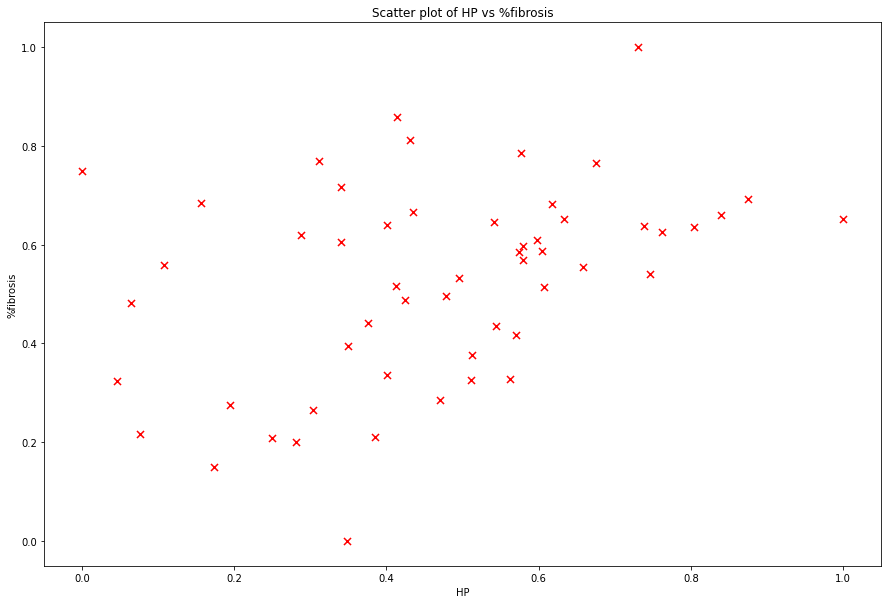

In [24]:
plt.figure(figsize=(15,10))
plt.title('Scatter plot of HP vs %fibrosis')
plt.scatter(x=df['HP'], y=df['%fibrosis'], s=50, c="red", marker="x")
plt.xlabel("HP")
plt.ylabel("%fibrosis")
plt.show()

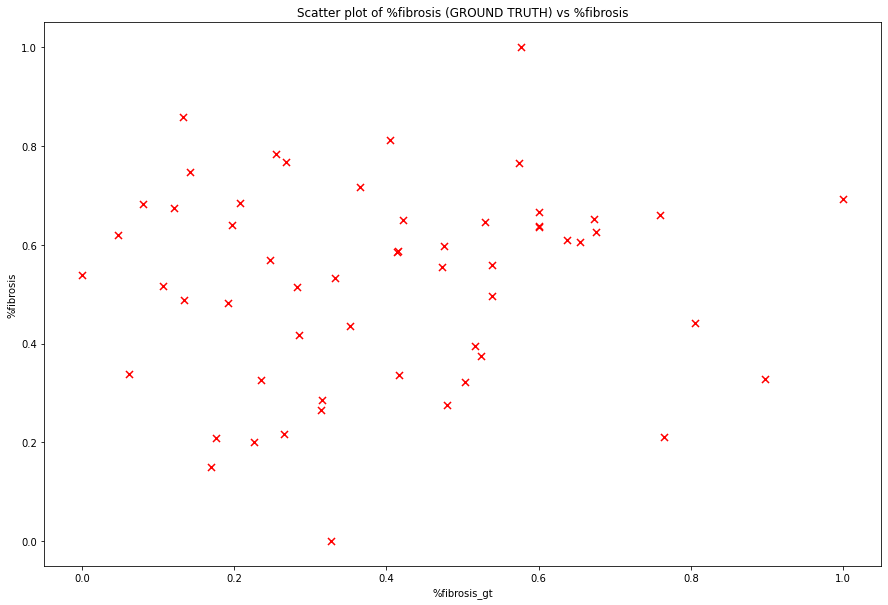

In [25]:
plt.figure(figsize=(15,10))
plt.title('Scatter plot of %fibrosis (GROUND TRUTH) vs %fibrosis')
plt.scatter(x=df['%fibrosis_gt'], y=df['%fibrosis'], s=50, c="red", marker="x")
plt.xlabel("%fibrosis_gt")
plt.ylabel("%fibrosis")
plt.show()

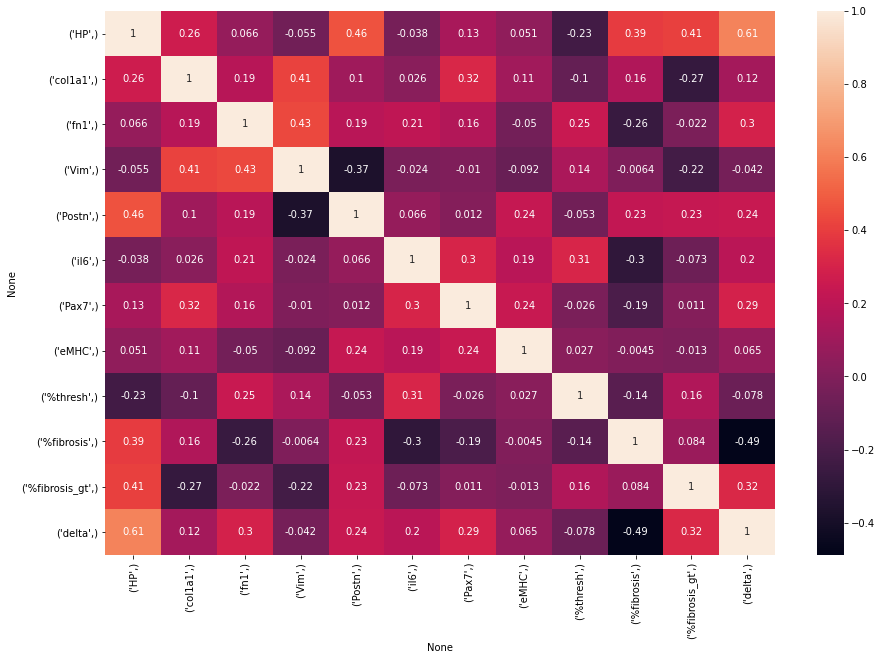

In [26]:
Var_Corr = df.corr(method='pearson')
# plot the heatmap and annotation on it
plt.figure(figsize=(15,10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)
plt.show()

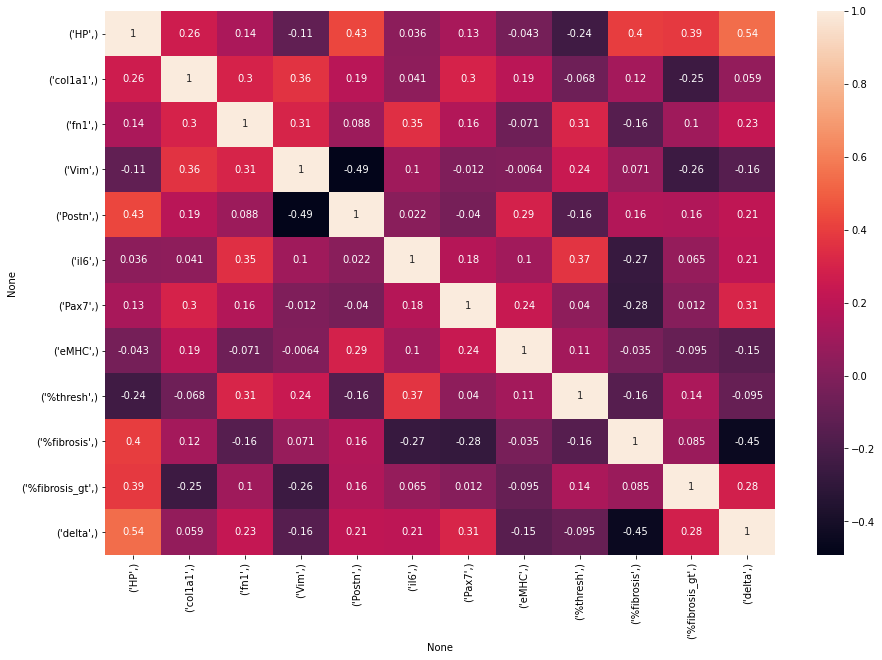

In [27]:
Var_Corr = df.corr(method='spearman')
# plot the heatmap and annotation on it
plt.figure(figsize=(15,10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)
plt.show()

In [28]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [29]:
calculate_pvalues(df) 

(HP,) (col1a1,)  (fn1,)  (Vim,) (Postn,)  (il6,) (Pax7,)  \
HP               0.0    0.0318   0.638   0.695   0.0013  0.8297  0.2189   
col1a1        0.0318       0.0  0.2262  0.0019   0.4232  0.6023  0.0331   
fn1            0.638    0.2262     0.0   0.001    0.216  0.0625  0.2961   
Vim            0.695    0.0019   0.001     0.0   0.0053  0.9041  0.9337   
Postn         0.0013    0.4232   0.216  0.0053      0.0   0.415  0.8342   
il6           0.8297    0.6023  0.0625  0.9041    0.415     0.0  0.0095   
Pax7          0.2189    0.0331  0.2961  0.9337   0.8342  0.0095     0.0   
eMHC          0.5929    0.5501  0.6388  0.4975   0.0657  0.0796  0.1092   
%thresh        0.065    0.5458  0.0402  0.3057   0.6927  0.0113  0.9601   
%fibrosis     0.0046    0.2451  0.0495  0.9397   0.1309  0.0533  0.1817   
%fibrosis_gt   0.005    0.0216   0.656  0.0929   0.2172  0.9605   0.959   
delta            0.0    0.3355  0.0312   0.764   0.1127  0.1453  0.0189   

             (eMHC,) (%thresh,) (%fibrosis,) (%fibrosis_gt,) (delta,)  
HP            0.5929      0.065       0.0046           0.005      0.0  
col1a1        0.5501     0.5458       0.2451          0.0216   0.3355  
fn1           0.6388     0.0402       0.0495           0.656   0.0312  
Vim           0.4975     0.3057       0.9397          0.0929    0.764  
Postn         0.0657     0.6927       0.1309          0.2172   0.1127  
il6           0.0796     0.0113       0.0533          0.9605   0.1453  
Pax7          0.1092     0.9601       0.1817           0.959   0.0189  
eMHC             0.0     0.7726       0.9411          0.8577   0.5735  
%thresh       0.7726        0.0       0.2174          0.1589   0.5257  
%fibrosis     0.9411     0.2174          0.0          0.6651   0.0001  
%fibrosis_gt  0.8577     0.1589       0.6651             0.0   0.0281  
delta         0.5735     0.5257       0.0001          0.0281      0.0